# Índice

#### <b><a href="#regresionlog">1. Regresion Logistica</a></b>
#### <b><a href="#naive">2. Naive Bayes</a></b>
#### <b><a href="#arbol">3. Árboles</a></b>
#### <b><a href="#cluster">4. Clustering</a></b>

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
from scipy.spatial.distance import pdist,squareform
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import accuracy_score,plot_confusion_matrix,roc_auc_score, classification_report, confusion_matrix, precision_recall_curve, auc, precision_score, recall_score
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.model_selection import StratifiedKFold
from imblearn.under_sampling import RandomUnderSampler

### Lectura del dataset

In [ ]:
data = pd.read_csv('./music_sentiments.csv', sep="\t")
data.shape

In [ ]:
data.head(5)

In [ ]:
#data.drop(columns=["Unnamed: 0"], inplace=True)
data.drop(columns=["artist", "album", "tokens", "char_count", "ignore_track", "track_name_clean", "album_release_year"], inplace=True)

In [ ]:
data.columns

In [ ]:
sns.heatmap(data.corr(), vmin=-1, vmax=1, center=0, cmap="YlGnBu")

### Features, Variable Target y Normalización

In [7]:
X = data.drop(columns=["genre"])
y = data["genre"]

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state = 0)

In [9]:
scaler = StandardScaler()
X_train_std = scaler.fit_transform(X_train)
X_test_std = scaler.transform(X_test)

### Función para evaluar modelos

In [10]:
def evaluate_model(model,X,y_true):
    '''
    Calcula las métricas ppales para evaluar un clasificador
    Toma como imput el modelo entrenado, el dataset de testeo y sus etiquetas
    '''
    y_pred=model.predict(X)
    y_proba=model.predict_proba(X)

    print(classification_report(y_true,y_pred))
    print('Area bajo la curva ROC:',np.round(roc_auc_score(y_true, y_proba, multi_class="ovo"),4))
    plot_confusion_matrix(model,X,y_true,cmap='Blues');
    return

----------------------------------

# <b><a id="regresionlog">1. Regresion Logistica</a></b>

In [11]:
lr = LogisticRegression(max_iter=1000)
lr.fit(X_train_std, y_train)

LogisticRegression(max_iter=1000)

In [12]:
y_pred=lr.predict(X_test_std)
y_proba=lr.predict_proba(X_test_std)

In [13]:
accuracy_score(y_train, lr.predict(X_train_std))

0.7502903600464577

              precision    recall  f1-score   support

 Heavy Metal       0.65      0.60      0.62       202
        Jazz       0.70      0.73      0.72        97
         Pop       0.82      0.86      0.84       195
   Punk Rock       0.57      0.58      0.58       211
 Rock n Roll       0.72      0.72      0.72       157

    accuracy                           0.69       862
   macro avg       0.69      0.70      0.70       862
weighted avg       0.69      0.69      0.69       862

Area bajo la curva ROC: 0.9235


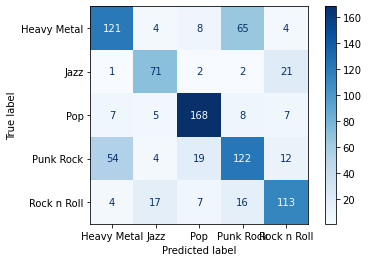

In [14]:
evaluate_model(lr, X_test_std, y_test)

#### <b><a id="regresionloggrid">1.2 GridSearch</a></b>

In [15]:
param_grid_lr = {'C': [1, 10, 100, 1000, 10000, 100000],
     'penalty': ["l2"],
     'solver': ['saga', "lbfgs"]}

In [16]:
folds = StratifiedKFold(n_splits=5, random_state=19, shuffle=True)

In [17]:
grid_lr = GridSearchCV(lr, param_grid_lr, cv=folds, scoring='accuracy', n_jobs=-2)

In [18]:
lr_fiteado = grid_lr.fit(X_train_std, y_train)

In [19]:
grid_lr.best_params_

{'C': 1, 'penalty': 'l2', 'solver': 'saga'}

In [20]:
grid_lr.best_score_

0.7073321038189915

              precision    recall  f1-score   support

 Heavy Metal       0.65      0.60      0.62       202
        Jazz       0.70      0.73      0.72        97
         Pop       0.83      0.86      0.84       195
   Punk Rock       0.57      0.58      0.58       211
 Rock n Roll       0.72      0.73      0.72       157

    accuracy                           0.69       862
   macro avg       0.69      0.70      0.70       862
weighted avg       0.69      0.69      0.69       862

Area bajo la curva ROC: 0.9236


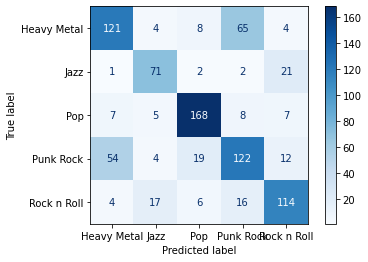

In [21]:
evaluate_model(grid_lr, X_test_std, y_test)

In [22]:
#logistic Regression
resultados_lr = [["Logistic Regression", accuracy_score(y_test,lr.predict(X_test_std)), precision_score(y_test,lr.predict(X_test_std), average="weighted"), recall_score(y_test,lr.predict(X_test_std), average="weighted")]]
resultados = pd.DataFrame(resultados_lr, columns=["modelo", "accuracy", "precision", "recall"])

#Logistic Regression Grid
resultados_grid_lr = [["Logistic Regression Grid", accuracy_score(y_test,grid_lr.predict(X_test_std)), precision_score(y_test,grid_lr.predict(X_test_std), average="weighted"), recall_score(y_test,grid_lr.predict(X_test_std), average="weighted")]]
resultados_grid_lr_df = pd.DataFrame(resultados_grid_lr, columns=["modelo", "accuracy", "precision", "recall"])

#Tabla final
resultados = resultados.append(resultados_grid_lr_df)

----------------------------------

# <b><a id="naive">2. Naive Bayes</a></b>

#### 2.1. Sin normalización

In [23]:
gnb = GaussianNB()
gnb.fit(X_train, y_train)

GaussianNB()

In [24]:
y_pred = gnb.predict(X_test)
y_pred_train = gnb.predict(X_train)
print("Accuracy test sin normalizar", accuracy_score(y_test, y_pred))
print("Accuracy train sin normalizar", accuracy_score(y_train, y_pred_train))

Accuracy test sin normalizar 0.4733178654292343
Accuracy train sin normalizar 0.49516066589237323


#### 2.2. Con normalización

In [25]:
gnb_std = GaussianNB()
gnb_std.fit(X_train_std, y_train)

GaussianNB()

In [26]:
y_pred_train_std = gnb_std.predict(X_train_std)
print("Accuracy train con normalización", accuracy_score(y_train, y_pred_train_std))

Accuracy train con normalización 0.49516066589237323


              precision    recall  f1-score   support

 Heavy Metal       0.58      0.50      0.54       202
        Jazz       0.43      0.82      0.57        97
         Pop       0.67      0.43      0.52       195
   Punk Rock       0.45      0.24      0.31       211
 Rock n Roll       0.35      0.59      0.44       157

    accuracy                           0.47       862
   macro avg       0.50      0.52      0.48       862
weighted avg       0.51      0.47      0.46       862

Area bajo la curva ROC: 0.8119


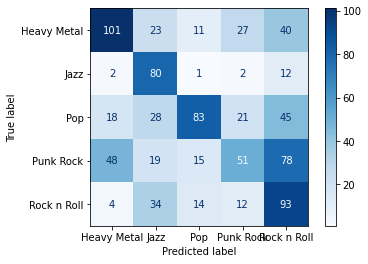

In [27]:
evaluate_model(gnb_std, X_test_std, y_test)

In [28]:
#Naive Bayes
resultados_gnb = [["Naive Bayes", accuracy_score(y_test,gnb.predict(X_test)), precision_score(y_test,gnb.predict(X_test), average="weighted"), recall_score(y_test,gnb.predict(X_test), average="weighted")]]
resultados_gnb_df = pd.DataFrame(resultados_gnb, columns=["modelo", "accuracy", "precision", "recall"])

#Naive Bayes Normalizado
resultados_gnb_std = [["Naive Bayes Normalizado", accuracy_score(y_test,gnb_std.predict(X_test_std)), precision_score(y_test,gnb_std.predict(X_test_std), average="weighted"), recall_score(y_test,gnb_std.predict(X_test_std), average="weighted")]]
resultados_gnb_std_df = pd.DataFrame(resultados_gnb_std, columns=["modelo", "accuracy", "precision", "recall"])

#Tabla final
resultados = resultados.append([resultados_gnb_df,resultados_gnb_std_df])

----------------------------------

# <b><a id="arbol">3. Árboles</a></b>

#### 3.1. Sin normalización

In [29]:
from sklearn import tree
clftree = tree.DecisionTreeClassifier(random_state=40)

In [30]:
clftree.fit(X_train, y_train)

DecisionTreeClassifier(random_state=40)

In [31]:
y_train_pred_tree = clftree.predict(X_train)
y_test_pred_tree = clftree.predict(X_test)

In [32]:
accuracy_score(y_train, y_train_pred_tree)

1.0

              precision    recall  f1-score   support

 Heavy Metal       0.64      0.52      0.57       202
        Jazz       0.62      0.62      0.62        97
         Pop       0.68      0.67      0.68       195
   Punk Rock       0.48      0.54      0.51       211
 Rock n Roll       0.60      0.68      0.64       157

    accuracy                           0.60       862
   macro avg       0.61      0.60      0.60       862
weighted avg       0.60      0.60      0.60       862

Area bajo la curva ROC: 0.752


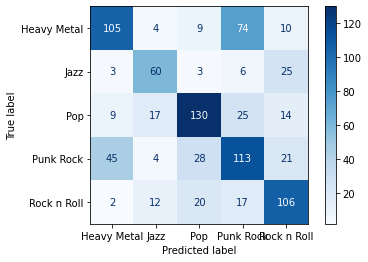

In [33]:
evaluate_model(clftree, X_test, y_test)

#### 3.2. Con normalización

In [34]:
clftree_std = tree.DecisionTreeClassifier(random_state=40)

In [35]:
clftree_std.fit(X_train_std, y_train)

DecisionTreeClassifier(random_state=40)

In [36]:
y_train_pred_tree_std = clftree_std.predict(X_train_std)
y_test_pred_tree_std = clftree_std.predict(X_test_std)

In [37]:
accuracy_score(y_train, y_train_pred_tree_std)

1.0

              precision    recall  f1-score   support

 Heavy Metal       0.61      0.55      0.58       202
        Jazz       0.66      0.67      0.66        97
         Pop       0.71      0.67      0.69       195
   Punk Rock       0.46      0.49      0.48       211
 Rock n Roll       0.60      0.67      0.63       157

    accuracy                           0.60       862
   macro avg       0.61      0.61      0.61       862
weighted avg       0.60      0.60      0.60       862

Area bajo la curva ROC: 0.756


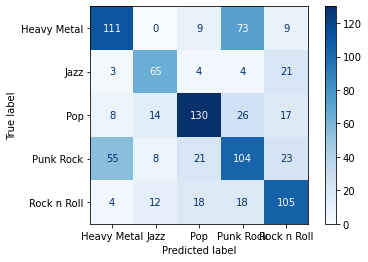

In [38]:
evaluate_model(clftree_std, X_test_std, y_test)

#### 3.3. GridSearch

In [39]:
params_grid = { "criterion" : ["gini", "entropy"],
                "min_samples_leaf": [5,10,15,20,None], 
                "max_depth" : [1,2,3,4,5,6,8,9,10,11,12,13,14,None],
                "min_samples_split": [2, 3, 4,None]}

In [40]:
grid_search = GridSearchCV(clftree, params_grid,
                           n_jobs=-2, scoring='accuracy')

In [41]:
grid_search.fit(X_train, y_train)

GridSearchCV(estimator=DecisionTreeClassifier(random_state=40), n_jobs=-2,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [1, 2, 3, 4, 5, 6, 8, 9, 10, 11, 12, 13,
                                       14, None],
                         'min_samples_leaf': [5, 10, 15, 20, None],
                         'min_samples_split': [2, 3, 4, None]},
             scoring='accuracy')

In [42]:
#Score durante el entrenamiento.
grid_search.best_score_

0.65002474022761

In [43]:
grid_search.best_params_ 

{'criterion': 'gini',
 'max_depth': 6,
 'min_samples_leaf': 5,
 'min_samples_split': 2}

In [44]:
cv_clf = grid_search.best_estimator_

In [45]:
cv_clf

DecisionTreeClassifier(max_depth=6, min_samples_leaf=5, random_state=40)

              precision    recall  f1-score   support

 Heavy Metal       0.71      0.50      0.59       202
        Jazz       0.58      0.82      0.68        97
         Pop       0.75      0.67      0.70       195
   Punk Rock       0.54      0.66      0.60       211
 Rock n Roll       0.67      0.64      0.66       157

    accuracy                           0.64       862
   macro avg       0.65      0.66      0.65       862
weighted avg       0.66      0.64      0.64       862

Area bajo la curva ROC: 0.8715


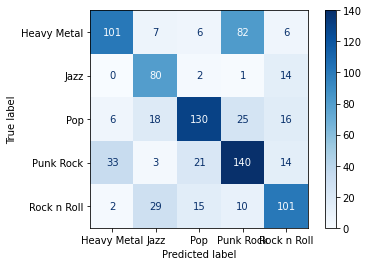

In [46]:
evaluate_model(cv_clf, X_test, y_test)

In [47]:
#Arbol
resultados_tree = [["Arbol", accuracy_score(y_test,clftree.predict(X_test)), precision_score(y_test,clftree.predict(X_test), average="weighted"), recall_score(y_test,clftree.predict(X_test), average="weighted")]]
resultados_tree_df = pd.DataFrame(resultados_tree, columns=["modelo", "accuracy", "precision", "recall"])

#Arbol Normalizado
resultados_tree_std = [["Arbol Normalizado", accuracy_score(y_test,clftree_std.predict(X_test_std)), precision_score(y_test,clftree_std.predict(X_test_std), average="weighted"), recall_score(y_test,clftree_std.predict(X_test_std), average="weighted")]]
resultados_tree_std_df = pd.DataFrame(resultados_tree_std, columns=["modelo", "accuracy", "precision", "recall"])

#Arbol Grid
resultados_tree_grid = [["Arbol Grid", accuracy_score(y_test,cv_clf.predict(X_test)), precision_score(y_test,cv_clf.predict(X_test), average="weighted"), recall_score(y_test,cv_clf.predict(X_test), average="weighted")]]
resultados_tree_grid_df = pd.DataFrame(resultados_tree_grid, columns=["modelo", "accuracy", "precision", "recall"])

#Tabla final
resultados = resultados.append([resultados_tree_df, resultados_tree_std_df, resultados_tree_grid_df])
resultados.reset_index(drop=True, inplace=True)

In [48]:
resultados

,modelo,accuracy,precision,recall
0,Logistic Regression,0.690255,0.688326,0.690255
1,Logistic Regression Grid,0.691415,0.689566,0.691415
2,Naive Bayes,0.473318,0.510835,0.473318
3,Naive Bayes Normalizado,0.473318,0.510835,0.473318
4,Arbol,0.596288,0.601818,0.596288
5,Arbol Normalizado,0.597448,0.601601,0.597448
6,Arbol Grid,0.640371,0.656053,0.640371


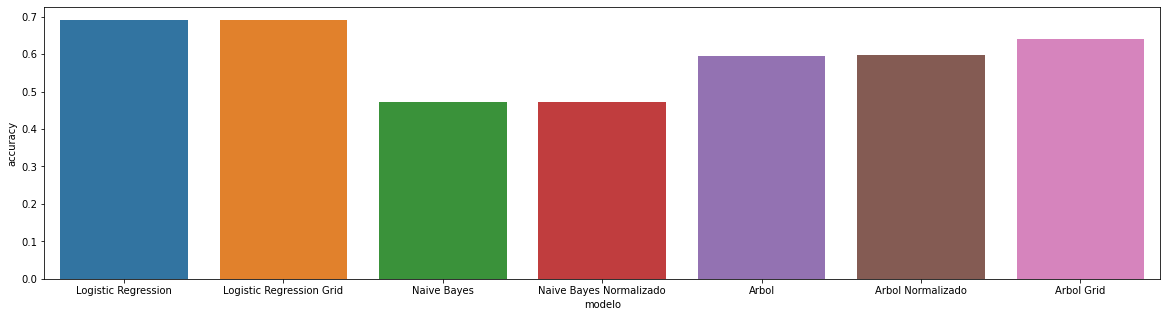

In [49]:
fig, ax = plt.subplots(figsize=(20,5)) 
ax = sns.barplot(x=resultados["modelo"], y=resultados["accuracy"])

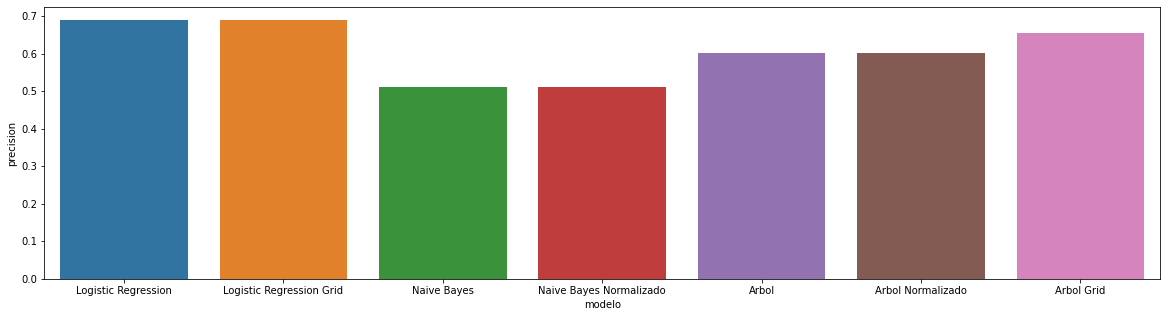

In [50]:
fig, ax = plt.subplots(figsize=(20,5)) 
ax = sns.barplot(x=resultados["modelo"], y=resultados["precision"])

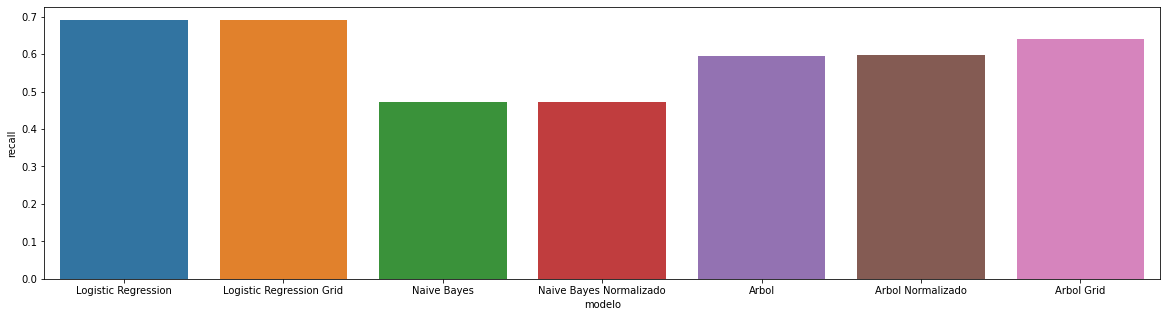

In [51]:
fig, ax = plt.subplots(figsize=(20,5)) 
ax = sns.barplot(x=resultados["modelo"], y=resultados["recall"])

----------------------------------

# <b><a id="cluster">4. Clustering</a></b>

In [52]:
#pca = PCA(n_components=2)
#principalComponents1 = pca.fit_transform(X_train_std)
#PCA_dataset1 = pd.DataFrame(data = principalComponents1, columns = ['component1', 'component2'] )
#principal_component1 = PCA_dataset1['component1']
#principal_component2 = PCA_dataset1['component2']

In [53]:
#plt.figure()
#plt.xlabel('Component 1')
#plt.ylabel('Component 2')
#plt.title('2 Component PCA')
#plt.scatter(PCA_dataset1['component1'], PCA_dataset1['component2']) #c = y_kmeans, s=10)

In [54]:
#kmeans = KMeans(n_clusters = 5, init = 'k-means++', random_state = 1)
#y_kmeans = kmeans.fit_predict(principalComponents1)
#labels = kmeans.labels_ # Etiquetas que indican a qué cluster pertenecen los datos
#centroids = kmeans.cluster_centers_ # Coordenadas de los centroides

In [55]:
#sns.scatterplot(x=principal_component1,y=principal_component2,hue=labels,legend='full',palette=sns.color_palette("hls", 5));
#plt.xlabel('Component 1',fontsize=15);plt.ylabel('Component 2',fontsize=15);
#plt.scatter(centroids[:,0],centroids[:,1],marker='x',s=50,color='k');

In [56]:
#data_clustering = data[['danceability', 'energy', 'loudness', 'mode', 'speechiness',
#       'instrumentalness', 'valence', 'tempo', 'time_signature',
#       'acousticness', 'anger', 'anticipation', 'disgust', 'fear', 'joy',
#       'negative', 'positive', 'sadness', 'surprise', 'trust']]

In [57]:
#k=5;
#km=KMeans(n_clusters=k, init = 'k-means++', random_state=0)
#km.fit(X)

#data_filtered=data.loc[data_clustering.index];
#f,ax=plt.subplots(2,3,figsize=(15,10),gridspec_kw={'wspace':0.5})
#ax=ax.ravel();
#for lbl in range(k):
#    S=data_filtered.loc[km.labels_==lbl,'genre'].value_counts(normalize=True);
#    chart=sns.barplot(y=S.index[:10],x=S.values[:10],ax=ax[lbl],orient='h')
#    chart.set_title('Cluster '+str(lbl))

In [58]:
#sq_distances=[]
#k_values=range(2,15);

#for k in k_values:
#    kmeans=KMeans(n_clusters=k,n_init=10,random_state=0) # Numero de repeticiones=10
#    kmeans.fit(X_train_std)
#    sq_distances.append(kmeans.inertia_)

#sns.lineplot(x=k_values,y=sq_distances,marker='o',size=30,legend=False);
#plt.ylabel('Suma Distancias Cuadráticas');plt.xlabel('Número de clusters');

In [59]:
#from sklearn.metrics import silhouette_score,silhouette_samples

#sil=[]
#k_values=range(2,15);

#for k in k_values:
#    kmeans=KMeans(n_clusters=k,n_init=15,random_state=0) # Numero de repeticiones=10
#    kmeans.fit(X_train_std)
#    score=silhouette_score(X_train_std,kmeans.labels_)
#    sil.append(score)

#sns.lineplot(x=k_values,y=sil,marker='o',size=30,legend=False);
#plt.ylabel('Silhouette score',fontsize=15);plt.xlabel('Número de clusters',fontsize=15);

In [60]:
#from sklearn.metrics import calinski_harabasz_score

#k_values=range(2,15);
#ch_scores=[]

#for k in k_values:
    
#    kmeans=KMeans(n_clusters=k,n_init=15,random_state=0) # Numero de repeticiones=10
#    kmeans.fit(X_train_std)
#    score=calinski_harabasz_score(X_train_std,kmeans.labels_)
#    ch_scores.append(score)

#sns.lineplot(x=k_values,y=ch_scores,marker='o',size=30,legend=False);
#plt.ylabel('Calinski-Harabasz',fontsize=15);plt.xlabel('Número de clusters',fontsize=15);
